# Loop to for hyperparameter search

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion,
                    load_intermediate_labels
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("./intermediate-labels/first_layer/train_images.pkl")
train_labels = load_intermediate_labels("./intermediate-labels/first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("./intermediate-labels/first_layer/val_images.pkl")
val_labels = load_intermediate_labels("./intermediate-labels/first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("./intermediate-labels/first_layer/test_images.pkl")
test_labels = load_intermediate_labels("./intermediate-labels/first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"./intermediate-labels-new/first_layer/F1/0.04/256_top.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

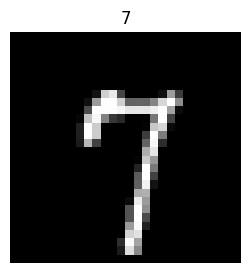

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

### Hyperparameters

In [15]:
min_loss = 0.01
max_loss = 0.10
step = 0.01
loss_factors = np.arange(min_loss, round(max_loss + step, 3), step)
print(len(loss_factors))
print(loss_factors)

10
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


### Training

In [16]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS,
                              worker_init_fn=seed_worker, generator=generator, pin_memory=True)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    # loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    del Z_train_one, Z_train_two, Z_test_one, Z_test_two
    del y_test, y_train
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.01




Epoch 1/20
  Train Loss: 1.1527
  SAE Train Loss (hidden one): 8.0155
  SAE Train Loss (hidden two): 1.0877
  Val Loss: 0.7325 | Val Acc: 79.66%
  Saved model with Val Acc: 79.66%


Epoch 2/20
  Train Loss: 0.5352
  SAE Train Loss (hidden one): 0.7648
  SAE Train Loss (hidden two): 0.1156
  Val Loss: 0.4474 | Val Acc: 86.82%
  Saved model with Val Acc: 86.82%


Epoch 3/20
  Train Loss: 0.4177
  SAE Train Loss (hidden one): 0.5735
  SAE Train Loss (hidden two): 0.0853
  Val Loss: 0.4178 | Val Acc: 87.76%
  Saved model with Val Acc: 87.76%


Epoch 4/20
  Train Loss: 0.3920
  SAE Train Loss (hidden one): 0.5573
  SAE Train Loss (hidden two): 0.0744
  Val Loss: 0.3826 | Val Acc: 89.14%
  Saved model with Val Acc: 89.14%


Epoch 5/20
  Train Loss: 0.3698
  SAE Train Loss (hidden one): 0.7569
  SAE Train Loss (hidden two): 0.0748
  Val Loss: 0.3682 | Val Acc: 89.62%
  Saved model with Val Acc: 89.62%


Epoch 6/20
  Train Loss: 0.3395
  SAE Train Loss (hidden one): 0.8403
  SAE Train Loss (hidden two): 0.0783
  Val Loss: 0.3504 | Val Acc: 90.32%
  Saved model with Val Acc: 90.32%


Epoch 7/20
  Train Loss: 0.3227
  SAE Train Loss (hidden one): 0.8484
  SAE Train Loss (hidden two): 0.0742
  Val Loss: 0.3311 | Val Acc: 90.66%
  Saved model with Val Acc: 90.66%


Epoch 8/20
  Train Loss: 0.3055
  SAE Train Loss (hidden one): 0.8917
  SAE Train Loss (hidden two): 0.0716
  Val Loss: 0.3249 | Val Acc: 90.53%


Epoch 9/20
  Train Loss: 0.2939
  SAE Train Loss (hidden one): 0.9728
  SAE Train Loss (hidden two): 0.0764
  Val Loss: 0.3337 | Val Acc: 90.08%


Epoch 10/20
  Train Loss: 0.2827
  SAE Train Loss (hidden one): 1.0107
  SAE Train Loss (hidden two): 0.0742
  Val Loss: 0.3016 | Val Acc: 91.16%
  Saved model with Val Acc: 91.16%


Epoch 11/20
  Train Loss: 0.2704
  SAE Train Loss (hidden one): 1.0246
  SAE Train Loss (hidden two): 0.0740
  Val Loss: 0.3020 | Val Acc: 91.65%
  Saved model with Val Acc: 91.65%


Epoch 12/20
  Train Loss: 0.2668
  SAE Train Loss (hidden one): 0.8773
  SAE Train Loss (hidden two): 0.0705
  Val Loss: 0.2875 | Val Acc: 91.72%
  Saved model with Val Acc: 91.72%


Epoch 13/20
  Train Loss: 0.2581
  SAE Train Loss (hidden one): 0.8765
  SAE Train Loss (hidden two): 0.0690
  Val Loss: 0.2842 | Val Acc: 91.84%
  Saved model with Val Acc: 91.84%


Epoch 14/20
  Train Loss: 0.2543
  SAE Train Loss (hidden one): 0.9821
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.2862 | Val Acc: 91.98%
  Saved model with Val Acc: 91.98%


Epoch 15/20
  Train Loss: 0.2513
  SAE Train Loss (hidden one): 0.8101
  SAE Train Loss (hidden two): 0.0631
  Val Loss: 0.3002 | Val Acc: 91.37%


Epoch 16/20
  Train Loss: 0.2467
  SAE Train Loss (hidden one): 0.7769
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2814 | Val Acc: 92.16%
  Saved model with Val Acc: 92.16%


Epoch 17/20
  Train Loss: 0.2433
  SAE Train Loss (hidden one): 0.9185
  SAE Train Loss (hidden two): 0.0610
  Val Loss: 0.2848 | Val Acc: 92.07%


Epoch 18/20
  Train Loss: 0.2441
  SAE Train Loss (hidden one): 0.7849
  SAE Train Loss (hidden two): 0.0596
  Val Loss: 0.2864 | Val Acc: 92.12%


Epoch 19/20
  Train Loss: 0.2395
  SAE Train Loss (hidden one): 0.7737
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.2886 | Val Acc: 91.91%


Epoch 20/20
  Train Loss: 0.2352
  SAE Train Loss (hidden one): 0.8034
  SAE Train Loss (hidden two): 0.0550
  Val Loss: 0.2951 | Val Acc: 91.79%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 253.75it/s]


Final Test Accuracy: 92.51%
Average Reconstruction Error (Hidden One): 1.0617
Average Reconstruction Error (Hidden Two): 0.0300
Average Non-Zero Features per Image (Hidden One): 33.48
Average Non-Zero Features per Image (Hidden Two): 34.95


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 87.18%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 79.76%

##################################################
Loss factor: 0.02




Epoch 1/20
  Train Loss: 1.0472
  SAE Train Loss (hidden one): 8.5573
  SAE Train Loss (hidden two): 1.1412
  Val Loss: 0.5330 | Val Acc: 84.59%
  Saved model with Val Acc: 84.59%


Epoch 2/20
  Train Loss: 0.4764
  SAE Train Loss (hidden one): 0.5249
  SAE Train Loss (hidden two): 0.0959
  Val Loss: 0.4524 | Val Acc: 86.35%
  Saved model with Val Acc: 86.35%


Epoch 3/20
  Train Loss: 0.4181
  SAE Train Loss (hidden one): 0.4905
  SAE Train Loss (hidden two): 0.0835
  Val Loss: 0.4151 | Val Acc: 88.20%
  Saved model with Val Acc: 88.20%


Epoch 4/20
  Train Loss: 0.4020
  SAE Train Loss (hidden one): 0.5119
  SAE Train Loss (hidden two): 0.0770
  Val Loss: 0.4017 | Val Acc: 88.23%
  Saved model with Val Acc: 88.23%


Epoch 5/20
  Train Loss: 0.3890
  SAE Train Loss (hidden one): 0.5030
  SAE Train Loss (hidden two): 0.0733
  Val Loss: 0.3835 | Val Acc: 88.73%
  Saved model with Val Acc: 88.73%


Epoch 6/20
  Train Loss: 0.3808
  SAE Train Loss (hidden one): 0.5378
  SAE Train Loss (hidden two): 0.0713
  Val Loss: 0.3652 | Val Acc: 89.37%
  Saved model with Val Acc: 89.37%


Epoch 7/20
  Train Loss: 0.3686
  SAE Train Loss (hidden one): 0.5730
  SAE Train Loss (hidden two): 0.0677
  Val Loss: 0.3941 | Val Acc: 88.63%


Epoch 8/20
  Train Loss: 0.3621
  SAE Train Loss (hidden one): 0.5706
  SAE Train Loss (hidden two): 0.0671
  Val Loss: 0.3636 | Val Acc: 89.12%


Epoch 9/20
  Train Loss: 0.3570
  SAE Train Loss (hidden one): 0.7249
  SAE Train Loss (hidden two): 0.0649
  Val Loss: 0.3658 | Val Acc: 89.50%
  Saved model with Val Acc: 89.50%


Epoch 10/20
  Train Loss: 0.3541
  SAE Train Loss (hidden one): 0.5802
  SAE Train Loss (hidden two): 0.0677
  Val Loss: 0.3813 | Val Acc: 89.11%


Epoch 11/20
  Train Loss: 0.3421
  SAE Train Loss (hidden one): 0.6048
  SAE Train Loss (hidden two): 0.0647
  Val Loss: 0.3564 | Val Acc: 89.71%
  Saved model with Val Acc: 89.71%


Epoch 12/20
  Train Loss: 0.3405
  SAE Train Loss (hidden one): 0.6479
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3518 | Val Acc: 89.48%


Epoch 13/20
  Train Loss: 0.3323
  SAE Train Loss (hidden one): 0.6775
  SAE Train Loss (hidden two): 0.0652
  Val Loss: 0.3598 | Val Acc: 89.53%


Epoch 14/20
  Train Loss: 0.3292
  SAE Train Loss (hidden one): 0.7034
  SAE Train Loss (hidden two): 0.0657
  Val Loss: 0.3628 | Val Acc: 89.37%


Epoch 15/20
  Train Loss: 0.3252
  SAE Train Loss (hidden one): 0.5601
  SAE Train Loss (hidden two): 0.0600
  Val Loss: 0.3558 | Val Acc: 89.59%


Epoch 16/20
  Train Loss: 0.3233
  SAE Train Loss (hidden one): 0.7640
  SAE Train Loss (hidden two): 0.0634
  Val Loss: 0.3347 | Val Acc: 90.00%
  Saved model with Val Acc: 90.00%


Epoch 17/20
  Train Loss: 0.3161
  SAE Train Loss (hidden one): 0.7189
  SAE Train Loss (hidden two): 0.0612
  Val Loss: 0.3426 | Val Acc: 90.15%
  Saved model with Val Acc: 90.15%


Epoch 18/20
  Train Loss: 0.3148
  SAE Train Loss (hidden one): 0.7006
  SAE Train Loss (hidden two): 0.0616
  Val Loss: 0.3220 | Val Acc: 90.57%
  Saved model with Val Acc: 90.57%


Epoch 19/20
  Train Loss: 0.3121
  SAE Train Loss (hidden one): 0.6877
  SAE Train Loss (hidden two): 0.0600
  Val Loss: 0.3307 | Val Acc: 90.09%


Epoch 20/20
  Train Loss: 0.3088
  SAE Train Loss (hidden one): 0.6293
  SAE Train Loss (hidden two): 0.0583
  Val Loss: 0.3611 | Val Acc: 89.50%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 286.89it/s]


Final Test Accuracy: 90.64%
Average Reconstruction Error (Hidden One): 0.4651
Average Reconstruction Error (Hidden Two): 0.0243
Average Non-Zero Features per Image (Hidden One): 33.27
Average Non-Zero Features per Image (Hidden Two): 33.99


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.34%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.01%

##################################################
Loss factor: 0.03




Epoch 1/20
  Train Loss: 1.0070
  SAE Train Loss (hidden one): 8.6491
  SAE Train Loss (hidden two): 1.1533
  Val Loss: 0.5142 | Val Acc: 84.63%
  Saved model with Val Acc: 84.63%


Epoch 2/20
  Train Loss: 0.4861
  SAE Train Loss (hidden one): 0.5116
  SAE Train Loss (hidden two): 0.0909
  Val Loss: 0.4448 | Val Acc: 86.29%
  Saved model with Val Acc: 86.29%


Epoch 3/20
  Train Loss: 0.4266
  SAE Train Loss (hidden one): 0.5670
  SAE Train Loss (hidden two): 0.0897
  Val Loss: 0.4269 | Val Acc: 87.44%
  Saved model with Val Acc: 87.44%


Epoch 4/20
  Train Loss: 0.3955
  SAE Train Loss (hidden one): 0.5832
  SAE Train Loss (hidden two): 0.0832
  Val Loss: 0.3740 | Val Acc: 88.81%
  Saved model with Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3747
  SAE Train Loss (hidden one): 0.5992
  SAE Train Loss (hidden two): 0.0786
  Val Loss: 0.3606 | Val Acc: 89.23%
  Saved model with Val Acc: 89.23%


Epoch 6/20
  Train Loss: 0.3583
  SAE Train Loss (hidden one): 0.6676
  SAE Train Loss (hidden two): 0.0799
  Val Loss: 0.3423 | Val Acc: 90.09%
  Saved model with Val Acc: 90.09%


Epoch 7/20
  Train Loss: 0.3415
  SAE Train Loss (hidden one): 0.6963
  SAE Train Loss (hidden two): 0.0801
  Val Loss: 0.3286 | Val Acc: 90.23%
  Saved model with Val Acc: 90.23%


Epoch 8/20
  Train Loss: 0.3316
  SAE Train Loss (hidden one): 0.7612
  SAE Train Loss (hidden two): 0.0776
  Val Loss: 0.3291 | Val Acc: 90.48%
  Saved model with Val Acc: 90.48%


Epoch 9/20
  Train Loss: 0.3187
  SAE Train Loss (hidden one): 0.6626
  SAE Train Loss (hidden two): 0.0711
  Val Loss: 0.3396 | Val Acc: 89.91%


Epoch 10/20
  Train Loss: 0.3153
  SAE Train Loss (hidden one): 0.6451
  SAE Train Loss (hidden two): 0.0704
  Val Loss: 0.3301 | Val Acc: 90.67%
  Saved model with Val Acc: 90.67%


Epoch 11/20
  Train Loss: 0.3110
  SAE Train Loss (hidden one): 0.6939
  SAE Train Loss (hidden two): 0.0672
  Val Loss: 0.3130 | Val Acc: 91.20%
  Saved model with Val Acc: 91.20%


Epoch 12/20
  Train Loss: 0.3064
  SAE Train Loss (hidden one): 0.6810
  SAE Train Loss (hidden two): 0.0644
  Val Loss: 0.3105 | Val Acc: 90.89%


Epoch 13/20
  Train Loss: 0.3009
  SAE Train Loss (hidden one): 0.6654
  SAE Train Loss (hidden two): 0.0638
  Val Loss: 0.3002 | Val Acc: 91.22%
  Saved model with Val Acc: 91.22%


Epoch 14/20
  Train Loss: 0.2947
  SAE Train Loss (hidden one): 0.6878
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.3317 | Val Acc: 90.68%


Epoch 15/20
  Train Loss: 0.2944
  SAE Train Loss (hidden one): 0.6716
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.3143 | Val Acc: 90.96%


Epoch 16/20
  Train Loss: 0.2902
  SAE Train Loss (hidden one): 0.7290
  SAE Train Loss (hidden two): 0.0586
  Val Loss: 0.3051 | Val Acc: 91.37%
  Saved model with Val Acc: 91.37%


Epoch 17/20
  Train Loss: 0.2878
  SAE Train Loss (hidden one): 0.7954
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3199 | Val Acc: 90.88%


Epoch 18/20
  Train Loss: 0.2891
  SAE Train Loss (hidden one): 0.6987
  SAE Train Loss (hidden two): 0.0546
  Val Loss: 0.3016 | Val Acc: 91.53%
  Saved model with Val Acc: 91.53%


Epoch 19/20
  Train Loss: 0.2829
  SAE Train Loss (hidden one): 0.7039
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.2987 | Val Acc: 91.57%
  Saved model with Val Acc: 91.57%


Epoch 20/20
  Train Loss: 0.2845
  SAE Train Loss (hidden one): 0.7117
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.3068 | Val Acc: 91.07%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 263.26it/s]

Final Test Accuracy: 91.19%
Average Reconstruction Error (Hidden One): 0.1408
Average Reconstruction Error (Hidden Two): 0.0107
Average Non-Zero Features per Image (Hidden One): 33.54
Average Non-Zero Features per Image (Hidden Two): 34.12



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.70%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.74%

##################################################
Loss factor: 0.04




Epoch 1/20
  Train Loss: 1.0596
  SAE Train Loss (hidden one): 8.5837
  SAE Train Loss (hidden two): 1.1450
  Val Loss: 0.5565 | Val Acc: 83.74%
  Saved model with Val Acc: 83.74%


Epoch 2/20
  Train Loss: 0.4926
  SAE Train Loss (hidden one): 0.4555
  SAE Train Loss (hidden two): 0.0969
  Val Loss: 0.4518 | Val Acc: 86.83%
  Saved model with Val Acc: 86.83%


Epoch 3/20
  Train Loss: 0.4370
  SAE Train Loss (hidden one): 0.4361
  SAE Train Loss (hidden two): 0.0775
  Val Loss: 0.4116 | Val Acc: 88.12%
  Saved model with Val Acc: 88.12%


Epoch 4/20
  Train Loss: 0.4202
  SAE Train Loss (hidden one): 0.4467
  SAE Train Loss (hidden two): 0.0719
  Val Loss: 0.3990 | Val Acc: 88.19%
  Saved model with Val Acc: 88.19%


Epoch 5/20
  Train Loss: 0.4044
  SAE Train Loss (hidden one): 0.4897
  SAE Train Loss (hidden two): 0.0705
  Val Loss: 0.3835 | Val Acc: 88.50%
  Saved model with Val Acc: 88.50%


Epoch 6/20
  Train Loss: 0.3940
  SAE Train Loss (hidden one): 0.5350
  SAE Train Loss (hidden two): 0.0659
  Val Loss: 0.3747 | Val Acc: 89.27%
  Saved model with Val Acc: 89.27%


Epoch 7/20
  Train Loss: 0.3885
  SAE Train Loss (hidden one): 0.5277
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.3694 | Val Acc: 89.35%
  Saved model with Val Acc: 89.35%


Epoch 8/20
  Train Loss: 0.3806
  SAE Train Loss (hidden one): 0.5527
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3629 | Val Acc: 89.27%


Epoch 9/20
  Train Loss: 0.3735
  SAE Train Loss (hidden one): 0.7426
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3613 | Val Acc: 89.79%
  Saved model with Val Acc: 89.79%


Epoch 10/20
  Train Loss: 0.3706
  SAE Train Loss (hidden one): 0.6018
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.3643 | Val Acc: 89.63%


Epoch 11/20
  Train Loss: 0.3647
  SAE Train Loss (hidden one): 0.6446
  SAE Train Loss (hidden two): 0.0583
  Val Loss: 0.3624 | Val Acc: 89.46%


Epoch 12/20
  Train Loss: 0.3618
  SAE Train Loss (hidden one): 0.7179
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.3518 | Val Acc: 89.63%


Epoch 13/20
  Train Loss: 0.3453
  SAE Train Loss (hidden one): 1.0621
  SAE Train Loss (hidden two): 0.0680
  Val Loss: 0.3326 | Val Acc: 90.02%
  Saved model with Val Acc: 90.02%


Epoch 14/20
  Train Loss: 0.3334
  SAE Train Loss (hidden one): 0.9396
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.3386 | Val Acc: 90.06%
  Saved model with Val Acc: 90.06%


Epoch 15/20
  Train Loss: 0.3302
  SAE Train Loss (hidden one): 0.8568
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.3301 | Val Acc: 90.16%
  Saved model with Val Acc: 90.16%


Epoch 16/20
  Train Loss: 0.3215
  SAE Train Loss (hidden one): 0.8705
  SAE Train Loss (hidden two): 0.0591
  Val Loss: 0.3188 | Val Acc: 90.54%
  Saved model with Val Acc: 90.54%


Epoch 17/20
  Train Loss: 0.3173
  SAE Train Loss (hidden one): 0.9638
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.3097 | Val Acc: 91.02%
  Saved model with Val Acc: 91.02%


Epoch 18/20
  Train Loss: 0.3132
  SAE Train Loss (hidden one): 0.7662
  SAE Train Loss (hidden two): 0.0571
  Val Loss: 0.3001 | Val Acc: 91.20%
  Saved model with Val Acc: 91.20%


Epoch 19/20
  Train Loss: 0.3106
  SAE Train Loss (hidden one): 0.8089
  SAE Train Loss (hidden two): 0.0595
  Val Loss: 0.3123 | Val Acc: 90.82%


Epoch 20/20
  Train Loss: 0.3066
  SAE Train Loss (hidden one): 0.7131
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3237 | Val Acc: 90.83%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 268.79it/s]


Final Test Accuracy: 91.70%
Average Reconstruction Error (Hidden One): 0.4884
Average Reconstruction Error (Hidden Two): 0.0189
Average Non-Zero Features per Image (Hidden One): 32.95
Average Non-Zero Features per Image (Hidden Two): 33.30


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.26%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.26%

##################################################
Loss factor: 0.05




Epoch 1/20
  Train Loss: 1.0377
  SAE Train Loss (hidden one): 8.7924
  SAE Train Loss (hidden two): 1.1582
  Val Loss: 0.5380 | Val Acc: 83.97%
  Saved model with Val Acc: 83.97%


Epoch 2/20
  Train Loss: 0.5092
  SAE Train Loss (hidden one): 0.4520
  SAE Train Loss (hidden two): 0.0924
  Val Loss: 0.4593 | Val Acc: 86.01%
  Saved model with Val Acc: 86.01%


Epoch 3/20
  Train Loss: 0.4491
  SAE Train Loss (hidden one): 0.4874
  SAE Train Loss (hidden two): 0.0799
  Val Loss: 0.4024 | Val Acc: 87.79%
  Saved model with Val Acc: 87.79%


Epoch 4/20
  Train Loss: 0.4288
  SAE Train Loss (hidden one): 0.5450
  SAE Train Loss (hidden two): 0.0747
  Val Loss: 0.3858 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


Epoch 5/20
  Train Loss: 0.4108
  SAE Train Loss (hidden one): 0.5399
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3973 | Val Acc: 88.02%


Epoch 6/20
  Train Loss: 0.4059
  SAE Train Loss (hidden one): 0.8667
  SAE Train Loss (hidden two): 0.0687
  Val Loss: 0.3719 | Val Acc: 89.00%
  Saved model with Val Acc: 89.00%


Epoch 7/20
  Train Loss: 0.3765
  SAE Train Loss (hidden one): 1.1609
  SAE Train Loss (hidden two): 0.0732
  Val Loss: 0.3438 | Val Acc: 90.13%
  Saved model with Val Acc: 90.13%


Epoch 8/20
  Train Loss: 0.3501
  SAE Train Loss (hidden one): 0.9683
  SAE Train Loss (hidden two): 0.0705
  Val Loss: 0.3105 | Val Acc: 90.90%
  Saved model with Val Acc: 90.90%


Epoch 9/20
  Train Loss: 0.3362
  SAE Train Loss (hidden one): 0.9424
  SAE Train Loss (hidden two): 0.0698
  Val Loss: 0.3275 | Val Acc: 90.37%


Epoch 10/20
  Train Loss: 0.3293
  SAE Train Loss (hidden one): 0.8123
  SAE Train Loss (hidden two): 0.0663
  Val Loss: 0.3198 | Val Acc: 90.58%


Epoch 11/20
  Train Loss: 0.3208
  SAE Train Loss (hidden one): 0.7807
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.3179 | Val Acc: 90.86%


Epoch 12/20
  Train Loss: 0.3174
  SAE Train Loss (hidden one): 0.7235
  SAE Train Loss (hidden two): 0.0619
  Val Loss: 0.3002 | Val Acc: 91.43%
  Saved model with Val Acc: 91.43%


Epoch 13/20
  Train Loss: 0.3115
  SAE Train Loss (hidden one): 0.7897
  SAE Train Loss (hidden two): 0.0599
  Val Loss: 0.3081 | Val Acc: 91.05%


Epoch 14/20
  Train Loss: 0.3074
  SAE Train Loss (hidden one): 0.6985
  SAE Train Loss (hidden two): 0.0581
  Val Loss: 0.3092 | Val Acc: 91.05%


Epoch 15/20
  Train Loss: 0.3055
  SAE Train Loss (hidden one): 0.6842
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.3087 | Val Acc: 91.01%


Epoch 16/20
  Train Loss: 0.3021
  SAE Train Loss (hidden one): 0.7367
  SAE Train Loss (hidden two): 0.0535
  Val Loss: 0.2925 | Val Acc: 91.66%
  Saved model with Val Acc: 91.66%


Epoch 17/20
  Train Loss: 0.2964
  SAE Train Loss (hidden one): 0.7133
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.2975 | Val Acc: 91.55%


Epoch 18/20
  Train Loss: 0.2955
  SAE Train Loss (hidden one): 0.6936
  SAE Train Loss (hidden two): 0.0520
  Val Loss: 0.2894 | Val Acc: 91.72%
  Saved model with Val Acc: 91.72%


Epoch 19/20
  Train Loss: 0.2945
  SAE Train Loss (hidden one): 0.7084
  SAE Train Loss (hidden two): 0.0528
  Val Loss: 0.3068 | Val Acc: 90.89%


Epoch 20/20
  Train Loss: 0.2906
  SAE Train Loss (hidden one): 0.6847
  SAE Train Loss (hidden two): 0.0485
  Val Loss: 0.3060 | Val Acc: 91.14%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 260.62it/s]

Final Test Accuracy: 92.36%
Average Reconstruction Error (Hidden One): 0.2190
Average Reconstruction Error (Hidden Two): 0.0142
Average Non-Zero Features per Image (Hidden One): 33.30
Average Non-Zero Features per Image (Hidden Two): 33.15



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.33%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.67%

##################################################
Loss factor: 0.060000000000000005




Epoch 1/20
  Train Loss: 1.1050
  SAE Train Loss (hidden one): 8.3137
  SAE Train Loss (hidden two): 1.1336
  Val Loss: 0.6339 | Val Acc: 83.74%
  Saved model with Val Acc: 83.74%


Epoch 2/20
  Train Loss: 0.6049
  SAE Train Loss (hidden one): 0.4819
  SAE Train Loss (hidden two): 0.0936
  Val Loss: 0.4885 | Val Acc: 85.78%
  Saved model with Val Acc: 85.78%


Epoch 3/20
  Train Loss: 0.4938
  SAE Train Loss (hidden one): 0.4677
  SAE Train Loss (hidden two): 0.0801
  Val Loss: 0.4267 | Val Acc: 87.42%
  Saved model with Val Acc: 87.42%


Epoch 4/20
  Train Loss: 0.4402
  SAE Train Loss (hidden one): 0.5241
  SAE Train Loss (hidden two): 0.0816
  Val Loss: 0.3889 | Val Acc: 88.57%
  Saved model with Val Acc: 88.57%


Epoch 5/20
  Train Loss: 0.4074
  SAE Train Loss (hidden one): 0.5470
  SAE Train Loss (hidden two): 0.0772
  Val Loss: 0.3690 | Val Acc: 89.09%
  Saved model with Val Acc: 89.09%


Epoch 6/20
  Train Loss: 0.3882
  SAE Train Loss (hidden one): 0.5200
  SAE Train Loss (hidden two): 0.0706
  Val Loss: 0.3589 | Val Acc: 89.70%
  Saved model with Val Acc: 89.70%


Epoch 7/20
  Train Loss: 0.3810
  SAE Train Loss (hidden one): 0.5784
  SAE Train Loss (hidden two): 0.0700
  Val Loss: 0.3459 | Val Acc: 90.08%
  Saved model with Val Acc: 90.08%


Epoch 8/20
  Train Loss: 0.3711
  SAE Train Loss (hidden one): 0.6016
  SAE Train Loss (hidden two): 0.0642
  Val Loss: 0.3388 | Val Acc: 90.25%
  Saved model with Val Acc: 90.25%


Epoch 9/20
  Train Loss: 0.3615
  SAE Train Loss (hidden one): 0.5708
  SAE Train Loss (hidden two): 0.0626
  Val Loss: 0.3522 | Val Acc: 89.90%


Epoch 10/20
  Train Loss: 0.3569
  SAE Train Loss (hidden one): 0.5120
  SAE Train Loss (hidden two): 0.0578
  Val Loss: 0.3361 | Val Acc: 90.36%
  Saved model with Val Acc: 90.36%


Epoch 11/20
  Train Loss: 0.3532
  SAE Train Loss (hidden one): 0.5647
  SAE Train Loss (hidden two): 0.0564
  Val Loss: 0.3215 | Val Acc: 90.70%
  Saved model with Val Acc: 90.70%


Epoch 12/20
  Train Loss: 0.3481
  SAE Train Loss (hidden one): 0.5925
  SAE Train Loss (hidden two): 0.0544
  Val Loss: 0.3295 | Val Acc: 90.12%


Epoch 13/20
  Train Loss: 0.3433
  SAE Train Loss (hidden one): 0.5177
  SAE Train Loss (hidden two): 0.0505
  Val Loss: 0.3190 | Val Acc: 90.58%


Epoch 14/20
  Train Loss: 0.3420
  SAE Train Loss (hidden one): 0.6022
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.3464 | Val Acc: 90.11%


Epoch 15/20
  Train Loss: 0.3375
  SAE Train Loss (hidden one): 0.6399
  SAE Train Loss (hidden two): 0.0512
  Val Loss: 0.3403 | Val Acc: 89.59%


Epoch 16/20
  Train Loss: 0.3338
  SAE Train Loss (hidden one): 0.5214
  SAE Train Loss (hidden two): 0.0495
  Val Loss: 0.3327 | Val Acc: 90.23%


Epoch 17/20
  Train Loss: 0.3311
  SAE Train Loss (hidden one): 0.5895
  SAE Train Loss (hidden two): 0.0493
  Val Loss: 0.3332 | Val Acc: 89.92%


Epoch 18/20
  Train Loss: 0.3277
  SAE Train Loss (hidden one): 0.5844
  SAE Train Loss (hidden two): 0.0485
  Val Loss: 0.3168 | Val Acc: 90.73%
  Saved model with Val Acc: 90.73%


Epoch 19/20
  Train Loss: 0.3286
  SAE Train Loss (hidden one): 0.6629
  SAE Train Loss (hidden two): 0.0485
  Val Loss: 0.3285 | Val Acc: 90.12%


Epoch 20/20
  Train Loss: 0.3238
  SAE Train Loss (hidden one): 0.6406
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3299 | Val Acc: 89.92%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 276.96it/s]


Final Test Accuracy: 90.85%
Average Reconstruction Error (Hidden One): 1.3070
Average Reconstruction Error (Hidden Two): 0.0111
Average Non-Zero Features per Image (Hidden One): 32.72
Average Non-Zero Features per Image (Hidden Two): 33.15


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.78%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.85%

##################################################
Loss factor: 0.06999999999999999




Epoch 1/20
  Train Loss: 1.0694
  SAE Train Loss (hidden one): 8.7240
  SAE Train Loss (hidden two): 1.1408
  Val Loss: 0.4884 | Val Acc: 85.79%
  Saved model with Val Acc: 85.79%


Epoch 2/20
  Train Loss: 0.5092
  SAE Train Loss (hidden one): 0.5752
  SAE Train Loss (hidden two): 0.0987
  Val Loss: 0.4367 | Val Acc: 87.06%
  Saved model with Val Acc: 87.06%


Epoch 3/20
  Train Loss: 0.4508
  SAE Train Loss (hidden one): 0.6849
  SAE Train Loss (hidden two): 0.0844
  Val Loss: 0.4089 | Val Acc: 87.93%
  Saved model with Val Acc: 87.93%


Epoch 4/20
  Train Loss: 0.4107
  SAE Train Loss (hidden one): 0.7034
  SAE Train Loss (hidden two): 0.0857
  Val Loss: 0.3396 | Val Acc: 90.37%
  Saved model with Val Acc: 90.37%


Epoch 5/20
  Train Loss: 0.3840
  SAE Train Loss (hidden one): 0.6665
  SAE Train Loss (hidden two): 0.0771
  Val Loss: 0.3509 | Val Acc: 89.89%


Epoch 6/20
  Train Loss: 0.3651
  SAE Train Loss (hidden one): 0.7106
  SAE Train Loss (hidden two): 0.0716
  Val Loss: 0.3410 | Val Acc: 90.66%
  Saved model with Val Acc: 90.66%


Epoch 7/20
  Train Loss: 0.3560
  SAE Train Loss (hidden one): 0.6543
  SAE Train Loss (hidden two): 0.0694
  Val Loss: 0.3204 | Val Acc: 90.85%
  Saved model with Val Acc: 90.85%


Epoch 8/20
  Train Loss: 0.3471
  SAE Train Loss (hidden one): 0.6339
  SAE Train Loss (hidden two): 0.0641
  Val Loss: 0.3002 | Val Acc: 91.18%
  Saved model with Val Acc: 91.18%


Epoch 9/20
  Train Loss: 0.3386
  SAE Train Loss (hidden one): 0.6783
  SAE Train Loss (hidden two): 0.0639
  Val Loss: 0.3171 | Val Acc: 90.84%


Epoch 10/20
  Train Loss: 0.3362
  SAE Train Loss (hidden one): 0.5906
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.3065 | Val Acc: 91.48%
  Saved model with Val Acc: 91.48%


Epoch 11/20
  Train Loss: 0.3276
  SAE Train Loss (hidden one): 0.6638
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3061 | Val Acc: 91.40%


Epoch 12/20
  Train Loss: 0.3235
  SAE Train Loss (hidden one): 0.6756
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2960 | Val Acc: 91.66%
  Saved model with Val Acc: 91.66%


Epoch 13/20
  Train Loss: 0.3197
  SAE Train Loss (hidden one): 0.6505
  SAE Train Loss (hidden two): 0.0585
  Val Loss: 0.3014 | Val Acc: 91.15%


Epoch 14/20
  Train Loss: 0.3176
  SAE Train Loss (hidden one): 0.6325
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.3078 | Val Acc: 91.03%


Epoch 15/20
  Train Loss: 0.3132
  SAE Train Loss (hidden one): 0.6769
  SAE Train Loss (hidden two): 0.0554
  Val Loss: 0.3085 | Val Acc: 91.18%


Epoch 16/20
  Train Loss: 0.3120
  SAE Train Loss (hidden one): 0.5760
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.2917 | Val Acc: 91.93%
  Saved model with Val Acc: 91.93%


Epoch 17/20
  Train Loss: 0.3063
  SAE Train Loss (hidden one): 0.7570
  SAE Train Loss (hidden two): 0.0533
  Val Loss: 0.2871 | Val Acc: 91.77%


Epoch 18/20
  Train Loss: 0.3066
  SAE Train Loss (hidden one): 0.6593
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.2941 | Val Acc: 91.75%


Epoch 19/20
  Train Loss: 0.3061
  SAE Train Loss (hidden one): 0.5844
  SAE Train Loss (hidden two): 0.0537
  Val Loss: 0.3071 | Val Acc: 91.08%


Epoch 20/20
  Train Loss: 0.3028
  SAE Train Loss (hidden one): 0.7163
  SAE Train Loss (hidden two): 0.0497
  Val Loss: 0.3052 | Val Acc: 91.34%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 269.25it/s]

Final Test Accuracy: 92.10%
Average Reconstruction Error (Hidden One): 0.6440
Average Reconstruction Error (Hidden Two): 0.0126
Average Non-Zero Features per Image (Hidden One): 33.92
Average Non-Zero Features per Image (Hidden Two): 34.74



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 86.03%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 78.24%

##################################################
Loss factor: 0.08




Epoch 1/20
  Train Loss: 1.0556
  SAE Train Loss (hidden one): 8.7021
  SAE Train Loss (hidden two): 1.1421
  Val Loss: 0.5028 | Val Acc: 84.94%
  Saved model with Val Acc: 84.94%


Epoch 2/20
  Train Loss: 0.5196
  SAE Train Loss (hidden one): 0.5173
  SAE Train Loss (hidden two): 0.0978
  Val Loss: 0.4167 | Val Acc: 87.79%
  Saved model with Val Acc: 87.79%


Epoch 3/20
  Train Loss: 0.4633
  SAE Train Loss (hidden one): 0.5554
  SAE Train Loss (hidden two): 0.0903
  Val Loss: 0.4319 | Val Acc: 86.86%


Epoch 4/20
  Train Loss: 0.4426
  SAE Train Loss (hidden one): 0.5681
  SAE Train Loss (hidden two): 0.0811
  Val Loss: 0.3769 | Val Acc: 88.97%
  Saved model with Val Acc: 88.97%


Epoch 5/20
  Train Loss: 0.4216
  SAE Train Loss (hidden one): 0.5909
  SAE Train Loss (hidden two): 0.0784
  Val Loss: 0.3656 | Val Acc: 88.95%


Epoch 6/20
  Train Loss: 0.4083
  SAE Train Loss (hidden one): 0.6376
  SAE Train Loss (hidden two): 0.0790
  Val Loss: 0.3397 | Val Acc: 90.03%
  Saved model with Val Acc: 90.03%


Epoch 7/20
  Train Loss: 0.3933
  SAE Train Loss (hidden one): 0.6487
  SAE Train Loss (hidden two): 0.0721
  Val Loss: 0.3489 | Val Acc: 89.76%


Epoch 8/20
  Train Loss: 0.3859
  SAE Train Loss (hidden one): 0.7043
  SAE Train Loss (hidden two): 0.0694
  Val Loss: 0.3292 | Val Acc: 90.63%
  Saved model with Val Acc: 90.63%


Epoch 9/20
  Train Loss: 0.3740
  SAE Train Loss (hidden one): 0.6953
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3337 | Val Acc: 90.51%


Epoch 10/20
  Train Loss: 0.3675
  SAE Train Loss (hidden one): 0.6567
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.3261 | Val Acc: 90.81%
  Saved model with Val Acc: 90.81%


Epoch 11/20
  Train Loss: 0.3537
  SAE Train Loss (hidden one): 0.7017
  SAE Train Loss (hidden two): 0.0626
  Val Loss: 0.3019 | Val Acc: 91.64%
  Saved model with Val Acc: 91.64%


Epoch 12/20
  Train Loss: 0.3528
  SAE Train Loss (hidden one): 0.7172
  SAE Train Loss (hidden two): 0.0590
  Val Loss: 0.3013 | Val Acc: 91.41%


Epoch 13/20
  Train Loss: 0.3445
  SAE Train Loss (hidden one): 0.7093
  SAE Train Loss (hidden two): 0.0567
  Val Loss: 0.3101 | Val Acc: 91.26%


Epoch 14/20
  Train Loss: 0.3425
  SAE Train Loss (hidden one): 0.7215
  SAE Train Loss (hidden two): 0.0553
  Val Loss: 0.3186 | Val Acc: 91.01%


Epoch 15/20
  Train Loss: 0.3406
  SAE Train Loss (hidden one): 0.6495
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.3216 | Val Acc: 90.99%


Epoch 16/20
  Train Loss: 0.3370
  SAE Train Loss (hidden one): 0.6730
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.2994 | Val Acc: 91.39%


Epoch 17/20
  Train Loss: 0.3345
  SAE Train Loss (hidden one): 0.7652
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3051 | Val Acc: 91.40%


Epoch 18/20
  Train Loss: 0.3326
  SAE Train Loss (hidden one): 0.6400
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.2938 | Val Acc: 91.90%
  Saved model with Val Acc: 91.90%


Epoch 19/20
  Train Loss: 0.3292
  SAE Train Loss (hidden one): 0.7051
  SAE Train Loss (hidden two): 0.0492
  Val Loss: 0.3014 | Val Acc: 91.61%


Epoch 20/20
  Train Loss: 0.3271
  SAE Train Loss (hidden one): 0.6943
  SAE Train Loss (hidden two): 0.0492
  Val Loss: 0.2997 | Val Acc: 91.75%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 257.87it/s]


Final Test Accuracy: 91.75%
Average Reconstruction Error (Hidden One): 0.4314
Average Reconstruction Error (Hidden Two): 0.0126
Average Non-Zero Features per Image (Hidden One): 33.43
Average Non-Zero Features per Image (Hidden Two): 33.30


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.47%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.99%

##################################################
Loss factor: 0.09




Epoch 1/20
  Train Loss: 1.0870
  SAE Train Loss (hidden one): 8.6888
  SAE Train Loss (hidden two): 1.1669
  Val Loss: 0.5487 | Val Acc: 84.05%
  Saved model with Val Acc: 84.05%


Epoch 2/20
  Train Loss: 0.5351
  SAE Train Loss (hidden one): 0.6066
  SAE Train Loss (hidden two): 0.1019
  Val Loss: 0.4583 | Val Acc: 86.14%
  Saved model with Val Acc: 86.14%


Epoch 3/20
  Train Loss: 0.4797
  SAE Train Loss (hidden one): 0.7311
  SAE Train Loss (hidden two): 0.0884
  Val Loss: 0.4221 | Val Acc: 87.96%
  Saved model with Val Acc: 87.96%


Epoch 4/20
  Train Loss: 0.4565
  SAE Train Loss (hidden one): 0.6380
  SAE Train Loss (hidden two): 0.0855
  Val Loss: 0.3836 | Val Acc: 88.93%
  Saved model with Val Acc: 88.93%


Epoch 5/20
  Train Loss: 0.4336
  SAE Train Loss (hidden one): 0.8008
  SAE Train Loss (hidden two): 0.0880
  Val Loss: 0.3872 | Val Acc: 88.62%


Epoch 6/20
  Train Loss: 0.4059
  SAE Train Loss (hidden one): 0.8805
  SAE Train Loss (hidden two): 0.0900
  Val Loss: 0.3638 | Val Acc: 89.60%
  Saved model with Val Acc: 89.60%


Epoch 7/20
  Train Loss: 0.3936
  SAE Train Loss (hidden one): 0.7741
  SAE Train Loss (hidden two): 0.0829
  Val Loss: 0.3377 | Val Acc: 90.33%
  Saved model with Val Acc: 90.33%


Epoch 8/20
  Train Loss: 0.3802
  SAE Train Loss (hidden one): 0.8056
  SAE Train Loss (hidden two): 0.0800
  Val Loss: 0.3447 | Val Acc: 89.72%


Epoch 9/20
  Train Loss: 0.3724
  SAE Train Loss (hidden one): 0.7888
  SAE Train Loss (hidden two): 0.0781
  Val Loss: 0.3450 | Val Acc: 90.02%


Epoch 10/20
  Train Loss: 0.3693
  SAE Train Loss (hidden one): 0.6578
  SAE Train Loss (hidden two): 0.0751
  Val Loss: 0.3591 | Val Acc: 89.62%


Epoch 11/20
  Train Loss: 0.3591
  SAE Train Loss (hidden one): 0.7729
  SAE Train Loss (hidden two): 0.0744
  Val Loss: 0.3478 | Val Acc: 89.93%


Epoch 12/20
  Train Loss: 0.3600
  SAE Train Loss (hidden one): 0.7382
  SAE Train Loss (hidden two): 0.0723
  Val Loss: 0.3161 | Val Acc: 91.02%
  Saved model with Val Acc: 91.02%


Epoch 13/20
  Train Loss: 0.3520
  SAE Train Loss (hidden one): 0.8099
  SAE Train Loss (hidden two): 0.0721
  Val Loss: 0.3519 | Val Acc: 89.81%


Epoch 14/20
  Train Loss: 0.3516
  SAE Train Loss (hidden one): 0.6980
  SAE Train Loss (hidden two): 0.0720
  Val Loss: 0.3233 | Val Acc: 90.68%


Epoch 15/20
  Train Loss: 0.3469
  SAE Train Loss (hidden one): 0.7470
  SAE Train Loss (hidden two): 0.0664
  Val Loss: 0.3170 | Val Acc: 90.90%


Epoch 16/20
  Train Loss: 0.3439
  SAE Train Loss (hidden one): 0.6510
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3254 | Val Acc: 90.68%


Epoch 17/20
  Train Loss: 0.3399
  SAE Train Loss (hidden one): 0.7770
  SAE Train Loss (hidden two): 0.0636
  Val Loss: 0.3115 | Val Acc: 91.05%
  Saved model with Val Acc: 91.05%


Epoch 18/20
  Train Loss: 0.3390
  SAE Train Loss (hidden one): 0.6850
  SAE Train Loss (hidden two): 0.0622
  Val Loss: 0.3027 | Val Acc: 91.47%
  Saved model with Val Acc: 91.47%


Epoch 19/20
  Train Loss: 0.3383
  SAE Train Loss (hidden one): 0.6931
  SAE Train Loss (hidden two): 0.0587
  Val Loss: 0.3538 | Val Acc: 89.92%


Epoch 20/20
  Train Loss: 0.3365
  SAE Train Loss (hidden one): 0.7430
  SAE Train Loss (hidden two): 0.0596
  Val Loss: 0.3133 | Val Acc: 91.29%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 258.51it/s]

Final Test Accuracy: 92.32%
Average Reconstruction Error (Hidden One): 0.1717
Average Reconstruction Error (Hidden Two): 0.0125
Average Non-Zero Features per Image (Hidden One): 33.16
Average Non-Zero Features per Image (Hidden Two): 35.28



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.68%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.97%

##################################################
Loss factor: 0.09999999999999999




Epoch 1/20
  Train Loss: 1.0255
  SAE Train Loss (hidden one): 9.2307
  SAE Train Loss (hidden two): 1.1990
  Val Loss: 0.4673 | Val Acc: 86.72%
  Saved model with Val Acc: 86.72%


Epoch 2/20
  Train Loss: 0.5032
  SAE Train Loss (hidden one): 0.5160
  SAE Train Loss (hidden two): 0.0945
  Val Loss: 0.4106 | Val Acc: 87.53%
  Saved model with Val Acc: 87.53%


Epoch 3/20
  Train Loss: 0.4562
  SAE Train Loss (hidden one): 0.5621
  SAE Train Loss (hidden two): 0.0876
  Val Loss: 0.3938 | Val Acc: 88.77%
  Saved model with Val Acc: 88.77%


Epoch 4/20
  Train Loss: 0.4311
  SAE Train Loss (hidden one): 0.6163
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3372 | Val Acc: 90.53%
  Saved model with Val Acc: 90.53%


Epoch 5/20
  Train Loss: 0.4108
  SAE Train Loss (hidden one): 0.8166
  SAE Train Loss (hidden two): 0.0794
  Val Loss: 0.3274 | Val Acc: 90.89%
  Saved model with Val Acc: 90.89%


Epoch 6/20
  Train Loss: 0.3814
  SAE Train Loss (hidden one): 0.9274
  SAE Train Loss (hidden two): 0.0876
  Val Loss: 0.2965 | Val Acc: 91.70%
  Saved model with Val Acc: 91.70%


Epoch 7/20
  Train Loss: 0.3633
  SAE Train Loss (hidden one): 0.8939
  SAE Train Loss (hidden two): 0.0829
  Val Loss: 0.3132 | Val Acc: 91.20%


Epoch 8/20
  Train Loss: 0.3465
  SAE Train Loss (hidden one): 0.9297
  SAE Train Loss (hidden two): 0.0819
  Val Loss: 0.2815 | Val Acc: 92.06%
  Saved model with Val Acc: 92.06%


Epoch 9/20
  Train Loss: 0.3371
  SAE Train Loss (hidden one): 0.8345
  SAE Train Loss (hidden two): 0.0742
  Val Loss: 0.2816 | Val Acc: 92.07%
  Saved model with Val Acc: 92.07%


Epoch 10/20
  Train Loss: 0.3329
  SAE Train Loss (hidden one): 0.8341
  SAE Train Loss (hidden two): 0.0731
  Val Loss: 0.2684 | Val Acc: 92.27%
  Saved model with Val Acc: 92.27%


Epoch 11/20
  Train Loss: 0.3229
  SAE Train Loss (hidden one): 0.9091
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.2752 | Val Acc: 92.40%
  Saved model with Val Acc: 92.40%


Epoch 12/20
  Train Loss: 0.3190
  SAE Train Loss (hidden one): 0.8140
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.2625 | Val Acc: 92.49%
  Saved model with Val Acc: 92.49%


Epoch 13/20
  Train Loss: 0.3152
  SAE Train Loss (hidden one): 0.8765
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.2539 | Val Acc: 92.75%
  Saved model with Val Acc: 92.75%


Epoch 14/20
  Train Loss: 0.3120
  SAE Train Loss (hidden one): 0.7833
  SAE Train Loss (hidden two): 0.0631
  Val Loss: 0.2648 | Val Acc: 92.53%


Epoch 15/20
  Train Loss: 0.3104
  SAE Train Loss (hidden one): 0.7967
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.2649 | Val Acc: 92.44%


Epoch 16/20
  Train Loss: 0.3059
  SAE Train Loss (hidden one): 0.8101
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.2584 | Val Acc: 92.59%


Epoch 17/20
  Train Loss: 0.3030
  SAE Train Loss (hidden one): 0.8177
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.2584 | Val Acc: 92.64%


Epoch 18/20
  Train Loss: 0.2999
  SAE Train Loss (hidden one): 0.6973
  SAE Train Loss (hidden two): 0.0564
  Val Loss: 0.2574 | Val Acc: 92.91%
  Saved model with Val Acc: 92.91%


Epoch 19/20
  Train Loss: 0.3002
  SAE Train Loss (hidden one): 0.8330
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.2593 | Val Acc: 92.79%


Epoch 20/20
  Train Loss: 0.2975
  SAE Train Loss (hidden one): 0.7735
  SAE Train Loss (hidden two): 0.0533
  Val Loss: 0.2562 | Val Acc: 92.68%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 283.99it/s]


Final Test Accuracy: 93.15%
Average Reconstruction Error (Hidden One): 0.3365
Average Reconstruction Error (Hidden Two): 0.0169
Average Non-Zero Features per Image (Hidden One): 34.23
Average Non-Zero Features per Image (Hidden Two): 34.19


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 93.01%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.60%



In [17]:
loss_data_dict.keys()

dict_keys([0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999])

In [18]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

0.09999999999999999
93.15
0.9301
0.926


In [20]:
import pickle

file_path = f"./loss_data_dict_{min_loss}_to_{round(loss_factors[-1], 3)}.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)